In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mzprojection import mzprojection_multivariate_discrete_time, split_long_time_series, calc_correlation

data = np.loadtxt("data/model1.dat")
nrec=int(data.shape[0]/1)
m=data.shape[1]
data=data[:nrec,:m]
print(data.shape)

t_raw = np.arange(nrec)
u_raw = data[:-1,:]
f_raw = data[1:,:]

(200000, 5)


In [2]:
#= Split a long time series data into samples of short-time data =
ista    = 10                # Start time step number for sampling   
nperiod = 10                # Time step length of a short-time sample                 
nshift  = 1                 # Length of time shift while sampling
t   =split_long_time_series(t_raw,ista=ista,nperiod=nperiod,nshift=nshift)
u   =split_long_time_series(u_raw,ista=ista,nperiod=nperiod,nshift=nshift)
f   =split_long_time_series(f_raw,ista=ista,nperiod=nperiod,nshift=nshift)

In [3]:
#= Mori-Zwanzig projection =
omega, memoryf, s, r = mzprojection_multivariate_discrete_time(u, f, flag_terms=True, flag_debug=True)

nsample= 199980 , nperiod= 10 , nu= 5 , nf= 5
# Prepare correlations [sec]: 0.024056673049926758
      uu0_inv[nu,nu].shape= (5, 5) float64
    G[nperiod,nu,nu].shape= (10, 5, 5) float64
      wG0_inv[nu,nu].shape= (5, 5) float64
# Calc. omega & memoryf [sec]: 0.023552894592285156
          omega[nf,nu].shape= (5, 5) float64
memoryf[nperiod,nf,nu].shape= (10, 5, 5) float64
# Calc. residual r [sec]: 0.31284499168395996
s[nsample,nperiod,nf].shape= (199980, 10, 5) float64
r[nsample,nperiod,nf].shape= (199980, 10, 5) float64


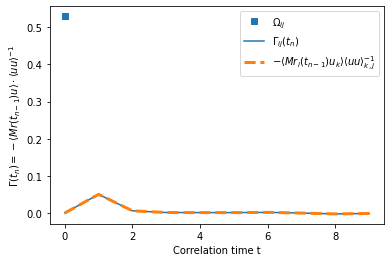

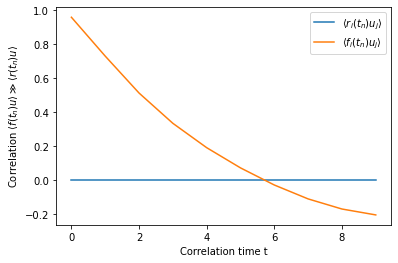

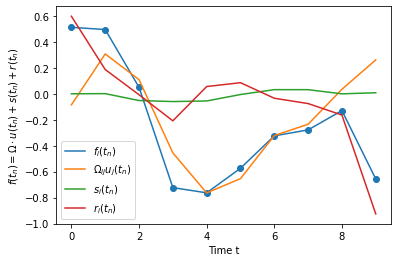

In [4]:
t_cor = np.arange(memoryf.shape[0])
nsample, nperiod, nu = u.shape
nf = f.shape[2]
u0 = u[:,0,:]
f0 = f[:,0,:]
r0 = r[:,0,:]
uu = calc_correlation(u,u0)
ff = calc_correlation(f,f0)
fu = calc_correlation(f,u0)
rr = calc_correlation(r,r0)
ru = calc_correlation(r,u0)
uu0_inv = np.linalg.inv(uu[0,:,:])
mr = r[:,:,:] - np.tensordot(u[:,0,:],memoryf[:,:,:],axes=((-1),(-1)))
mru = calc_correlation(mr,u0)
uu1_inv = np.linalg.inv(uu[1,:,:])

i,j=1,1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel(r"$\Gamma(t_n) = - \langle M r(t_{n-1}) u \rangle \cdot \langle u u \rangle^{-1}$")
ax.plot(0,omega[i,j],"s",label="$\Omega_{ij}$")
ax.plot(t_cor,memoryf[:,i,j],label="$\Gamma_{ij}(t_n)$",c="C0")
ax.plot(t_cor,np.dot(-mru,uu0_inv)[:,i,j],"--",label=r"$-\langle Mr_i(t_{n-1}) u_k \rangle \langle u u \rangle^{-1}_{k,j}$",lw=3)
# ax.plot(t_cor,np.dot(rr,uu1_inv.T)[:,i,j],"--",label=r"$-\langle Mr_i(t_{n-1}) u_k \rangle \langle u u \rangle^{-1}_{k,j}$",lw=3) # Lin'21arXiv
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel(r"Correlation $\langle f(t_n) u \rangle \gg \langle r(t_n) u \rangle$")
ax.plot(t_cor,ru[:,i,j],label=r"$\langle r_i(t_n) u_j \rangle$")
ax.plot(t_cor,fu[:,i,j],label=r"$\langle f_i(t_n) u_j \rangle$")
plt.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time t")
ax.set_ylabel("$f(t_n)=\Omega \cdot u(t_n) + s(t_n) + r(t_n)$")
ax.plot(t_cor,f[10,:,i],label="$f_i(t_n)$")
ax.plot(t_cor,np.dot(u[10,:,:],omega.T)[:,i],label="$\Omega_{ij} u_j(t_n)$")
ax.plot(t_cor,s[10,:,i],label="$s_i(t_n)$")
ax.plot(t_cor,r[10,:,i],label="$r_i(t_n)$")
ax.scatter(t_cor,np.dot(u[10,:,:],omega.T)[:,i]+s[10,:,i]+r[10,:,i])
plt.legend()
plt.show()

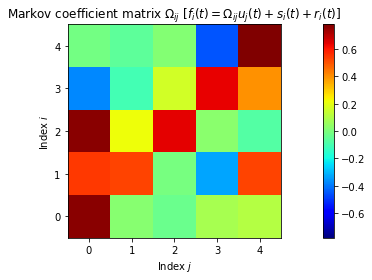

In [5]:
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(111)
vmax=np.max(abs(omega))
quad = ax.pcolormesh(np.arange(nu),np.arange(nf),omega[:,:],
                     cmap='jet',shading="auto",vmin=-vmax,vmax=vmax)
ax.set_xlabel(r"Index $j$")
ax.set_ylabel(r"Index $i$")
ax.set_title(r"Markov coefficient matrix $\Omega_{ij}$ [$f_i(t)=\Omega_{ij}u_j(t)+s_i(t)+r_i(t)$]")
ax.set_aspect("equal")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

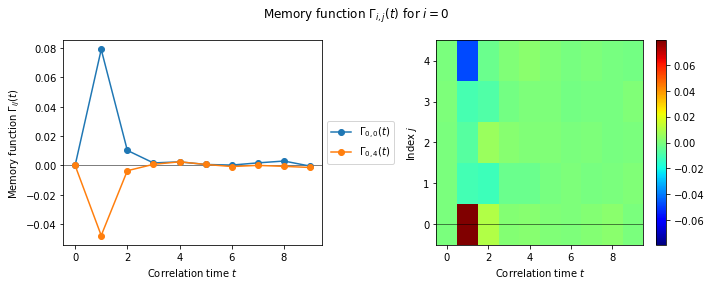

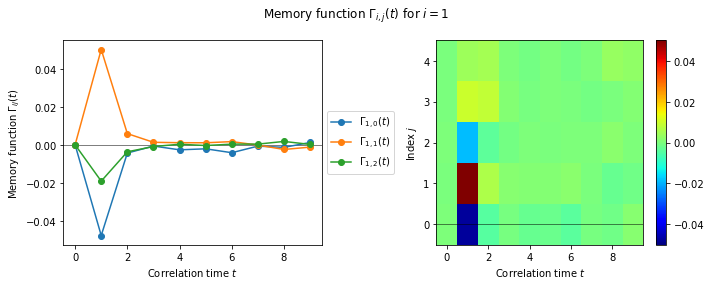

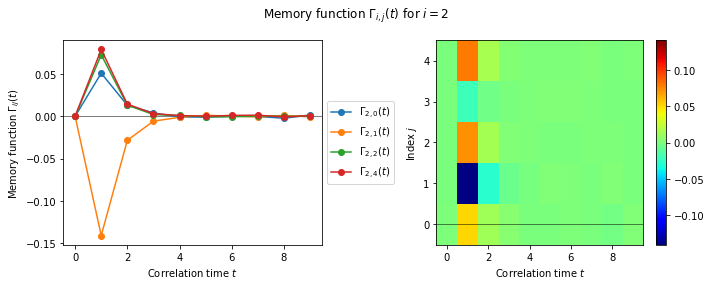

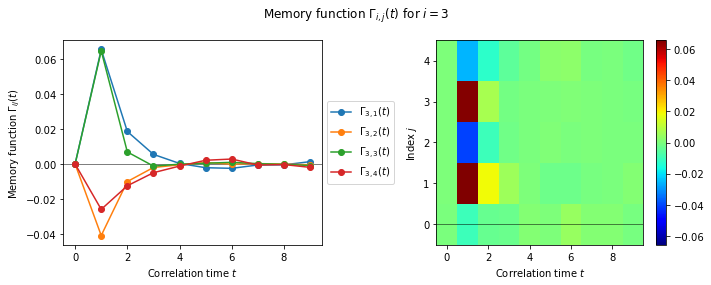

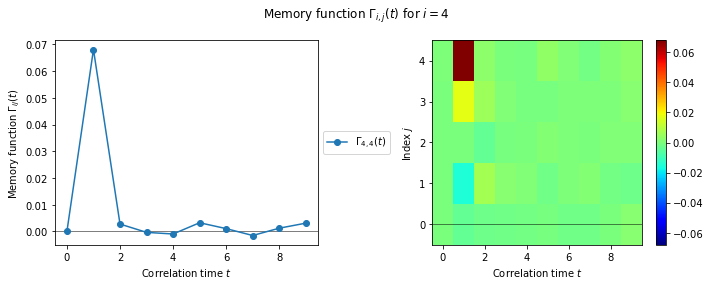

In [6]:
def plot_memoryf(t_cor,memoryf,i=0):
    fig = plt.figure(figsize=(10,4))
    ax=fig.add_subplot(121)
    ax.axhline(0,lw=0.5,c="k")
    vmax=np.max(abs(memoryf[:,i,:]))
    for j in range(nu):
        vmax_j=np.max(abs(memoryf[:,i,j]))
        if vmax_j > 0.3*vmax:
            ax.plot(t_cor,memoryf[:,i,j],"o-",label="$\Gamma_{"+"{:},{:}".format(i,j)+"}(t)$")
    ax.set_xlabel(r"Correlation time $t$")
    ax.set_ylabel(r"Memory function $\Gamma_{ij}(t)$")
    ax.legend(loc="center left",bbox_to_anchor=(1,0.5))

    ax=fig.add_subplot(122)
    ax.axhline(0,lw=0.5,c="k")
    vmax=np.max(abs(memoryf[:,i,:]))
    quad = ax.pcolormesh(t_cor,np.arange(nu),memoryf[:,i,:].T,
                         cmap='jet',shading="auto",vmin=-vmax,vmax=vmax)
    ax.set_xlabel(r"Correlation time $t$")
    ax.set_ylabel(r"Index $j$")
    fig.colorbar(quad)
    fig.suptitle(r"Memory function $\Gamma_{i,j}(t)$ for $i="+r"{:}$".format(i))
    fig.tight_layout()

    
for i in range(nf):
    plot_memoryf(t_cor,memoryf,i); plt.show()

# Compare with SVAR
### (i) Markov coefficient and memory function

A_1=
 [[ 0.7640  0.0241 -0.0344  0.0832  0.1051]
 [ 0.5442  0.5298 -0.0119 -0.3312  0.5305]
 [ 0.7660  0.2187  0.6437  0.0255 -0.0743]
 [-0.3744 -0.1095  0.1631  0.6394  0.3980]
 [-0.0129 -0.0555  0.0165 -0.4567  0.7808]]


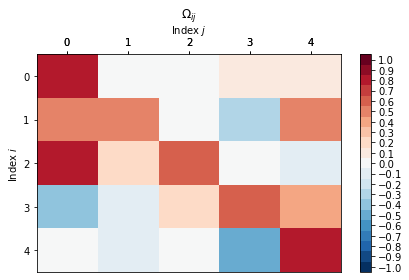

A_2=
 [[-0.0791  0.0109  0.0071  0.0101  0.0478]
 [ 0.0478 -0.0502  0.0192 -0.0095 -0.0041]
 [-0.0510  0.1409 -0.0726  0.0219 -0.0790]
 [ 0.0099 -0.0657  0.0410 -0.0649  0.0260]
 [ 0.0040  0.0151  0.0004 -0.0174 -0.0681]]


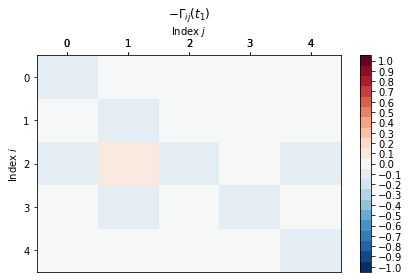

A_3=
 [[-0.0103  0.0119 -0.0061  0.0086  0.0036]
 [ 0.0043 -0.0059  0.0037 -0.0083 -0.0051]
 [-0.0130  0.0284 -0.0132  0.0040 -0.0144]
 [ 0.0031 -0.0187  0.0101 -0.0069  0.0125]
 [ 0.0026 -0.0064  0.0042 -0.0053 -0.0028]]


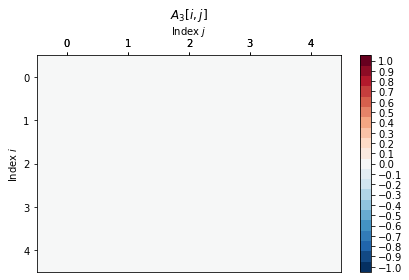

In [7]:
A1 = omega-memoryf[0]
A2 = -memoryf[1]
A3 = -memoryf[2]

from matplotlib import colors
cmap = plt.cm.RdBu_r
bounds = np.linspace(-1.05, 1.05, 22)
norm = colors.BoundaryNorm(bounds, cmap.N)

np.set_printoptions(precision=4, floatmode='fixed',suppress=True)
print("A_1=\n",A1)
fig=plt.figure()
ax=fig.add_subplot(111)
quad = ax.pcolormesh(np.arange(m),np.arange(m),A1,
                     cmap=cmap,norm=norm,shading="auto")
ax.set_ylim(m-0.5,0-0.5)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"$\Omega_{ij}$")
# ax.set_title(r"$A_1[i,j]$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 21))
fig.tight_layout()
plt.show()

print("A_2=\n",A2)
fig=plt.figure()
ax=fig.add_subplot(111)
quad = ax.pcolormesh(np.arange(m),np.arange(m),A2,
                     cmap=cmap,norm=norm,shading="auto")
ax.set_ylim(m-0.5,0-0.5)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"$-\Gamma_{ij}(t_1)$")
# ax.set_title(r"$A_2[i,j]$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 21))
fig.tight_layout()
plt.show()

print("A_3=\n",A3)
fig=plt.figure()
ax=fig.add_subplot(111)
quad = ax.pcolormesh(np.arange(m),np.arange(m),A3,
                     cmap=cmap,norm=norm,shading="auto")
ax.set_ylim(m-0.5,0-0.5)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"$A_3[i,j]$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 21))
fig.tight_layout()
plt.show()

### (ii) Statistics of the uncorrelated term

r_0: average= -0.0007 , variance=  0.1035
r_1: average=  0.0007 , variance=  0.1459
r_2: average= -0.0016 , variance=  0.1076
r_3: average=  0.0020 , variance=  0.1256
r_4: average=  0.0009 , variance=  0.1028


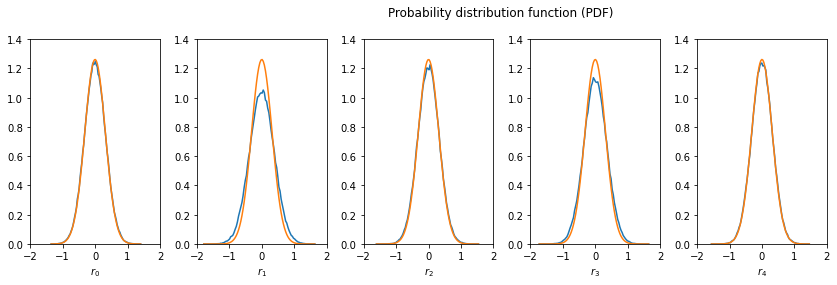

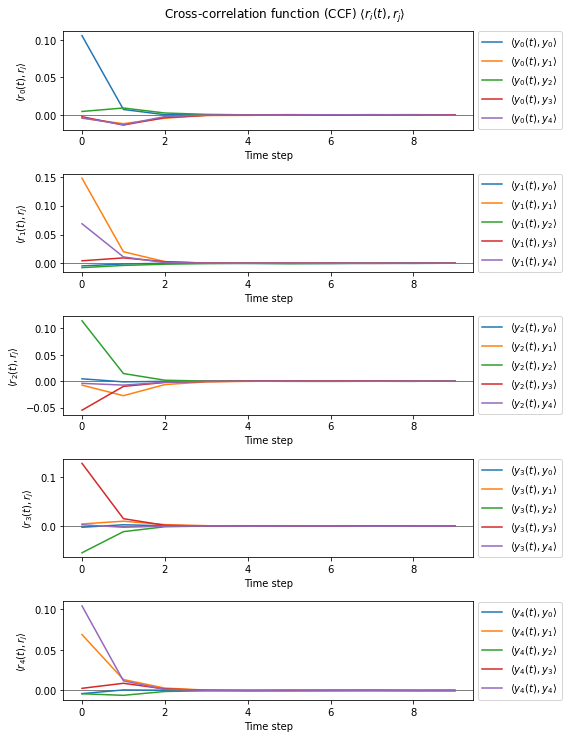

In [8]:
for im in range(m):
    ave = np.average(r[:,:,im])
    var = np.var(r[:,:,im])
    print(r"r_{:}".format(im)+": average={:8.4f}".format(ave),", variance={:8.4f}".format(var))

def gaussian(x,mean=0,std=1):
    return np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)

fig = plt.figure(figsize=(14,4))
ncol=6
for im in range(m):
    ax = plt.subplot2grid((int(m/ncol)+1,ncol), (int(im/ncol),im%ncol))
    d = r[:,:,im]
    x_hist, bins = np.histogram(d,bins=100)
    x_range = (bins[:-1] + bins[1:])/2
    bin_width = bins[1]-bins[0]
    pdf = x_hist / d.size / bin_width
    #print("# Check normalization of PDF", np.sum(pdf)*bin_width)
    ax.plot(x_range,pdf)
    ax.plot(x_range,gaussian(x_range,mean=0,std=np.sqrt(0.1)))
    ax.set_xlabel("$r_{:}$".format(im))
    ax.set_ylim(0,1.4)
    ax.set_xlim(-2,2)
fig.suptitle("Probability distribution function (PDF)")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,12))
ncol=1
for im1 in range(m):
    ax = plt.subplot2grid((int(m/ncol)+1,ncol), (int(im1/ncol),im1%ncol))
    ax.axhline(0,lw=0.5,c="k")
    for im2 in range(m):
        ax.plot(rr[:,im1,im2],label=r"$\langle y_{:}(t),y_{:} \rangle$".format(im1,im2))
        ax.set_xlabel(r"Time step")
        ax.set_ylabel(r"$\langle r_{:}(t),r_j \rangle$".format(im1))
        #ax.set_xlim(0,9)
        ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
fig.suptitle(r"Cross-correlation function (CCF) $\langle r_i(t),r_j \rangle$")
fig.tight_layout()
plt.show()

### (iii) Reproduce simulation data based on MZ coefficients 

[-0.0007  0.0007 -0.0016  0.0020  0.0009] [[ 0.1057 -0.0045  0.0046 -0.0024 -0.0038]
 [-0.0045  0.1477 -0.0075  0.0044  0.0687]
 [ 0.0046 -0.0075  0.1143 -0.0549 -0.0040]
 [-0.0024  0.0044 -0.0549  0.1290  0.0027]
 [-0.0038  0.0687 -0.0040  0.0027  0.1039]]
(200000, 5)


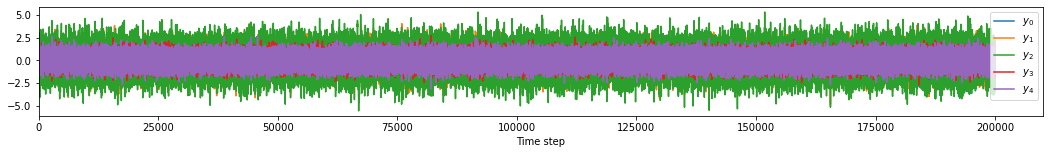

In [9]:
p=nperiod

A=np.zeros([p+1,m,m])
A[1,:,:] = omega-memoryf[0,:,:]
A[2:,:,:] = -memoryf[1:,:,:]
A0inv = np.linalg.inv(np.identity(m)-A[0,:,:])
e_var=[np.var(r[:,:,im]) for im in range(m)]
r_mean=np.average(r[:,:,:],axis=(0,1))
r_cov=rr[0,:,:]
print(r_mean,r_cov)

nrec = 200000
yprev = np.random.normal(loc=0.0,scale=np.sqrt(0.1),size=(p,m))
y = [*yprev]
for t in range(nrec-p):
#     aype = np.random.normal(loc=0.0,scale=np.sqrt(e_var),size=(m))
    aype = np.random.multivariate_normal(mean=r_mean,cov=r_cov)
    for i in range(1,A.shape[0]):
        aype = aype + np.dot(A[i,:,:],y[-i])
    yt = np.dot(A0inv,aype)
    y.append(yt)
y=np.array(y)
print(y.shape)

fig=plt.figure(figsize=(18,2))
ax=fig.add_subplot(111)
for im in range(m):
    ax.plot(y[:,im],label="$y_{:}$".format(im))
ax.set_xlabel("Time step")
ax.set_xlim(0,None)
ax.legend()
plt.show()

y_0: average=  0.0000 , variance=  0.2582
y_1: average=  0.0010 , variance=  1.0023
y_2: average= -0.0006 , variance=  1.6176
y_3: average=  0.0018 , variance=  0.3218
y_4: average= -0.0001 , variance=  0.3653


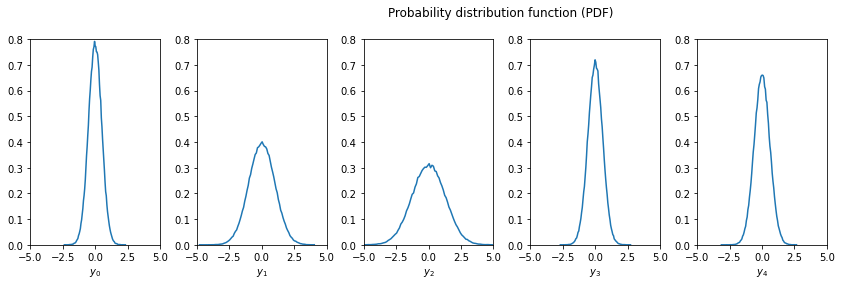

In [10]:
for im in range(m):
    ave = np.average(y[:,im])
    var = np.var(y[:,im])
    print(r"y_{:}".format(im)+": average={:8.4f}".format(ave),", variance={:8.4f}".format(var))

fig = plt.figure(figsize=(14,4))
ncol=6
for im in range(m):
    ax = plt.subplot2grid((int(m/ncol)+1,ncol), (int(im/ncol),im%ncol))
    d = y[:,im]
    x_hist, bins = np.histogram(d,bins=100)
    x_range = (bins[:-1] + bins[1:])/2
    bin_width = bins[1]-bins[0]
    pdf = x_hist / d.size / bin_width
    #print("# Check normalization of PDF", np.sum(pdf)*bin_width)
    ax.plot(x_range,pdf)
    ax.set_xlabel("$y_{:}$".format(im))
    ax.set_ylim(0,0.8)
    ax.set_xlim(-5,5)
fig.suptitle("Probability distribution function (PDF)")
fig.tight_layout()
plt.show()

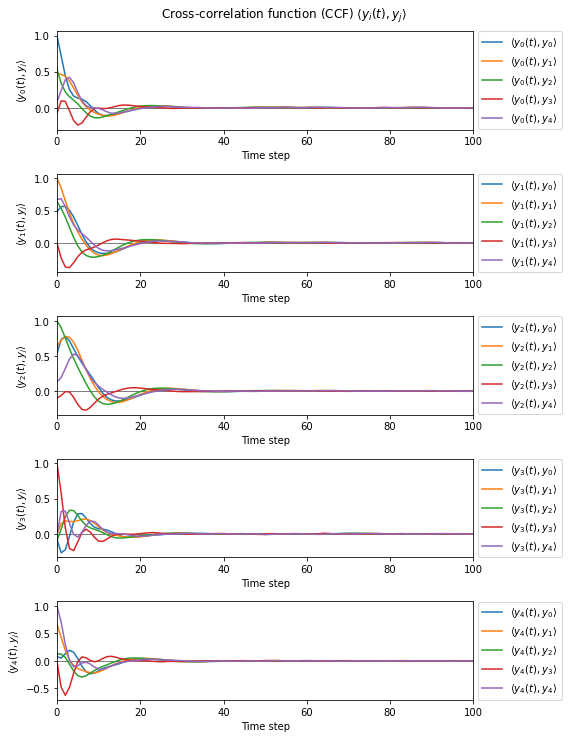

In [11]:
fig = plt.figure(figsize=(8,12))
ncol=1
for im1 in range(m):
    ax = plt.subplot2grid((int(m/ncol)+1,ncol), (int(im1/ncol),im1%ncol))
    d1 = y[:,im1]
    d1 = d1 - np.average(d1)
    ax.axhline(0,lw=0.5,c="k")
    for im2 in range(m):
        d2 = y[:,im2]
        d2 = d2 - np.average(d2)
        ccf = np.correlate(d1,d2,mode="full")[len(d1)-1:]
        ccf = ccf / np.sqrt(np.sum(d1*d1)*np.sum(d2*d2))
        ax.plot(ccf[:],label=r"$\langle y_{:}(t),y_{:} \rangle$".format(im1,im2))
        ax.set_xlabel(r"Time step")
        ax.set_ylabel(r"$\langle y_{:}(t),y_j \rangle$".format(im1))
        ax.set_xlim(0,100)
        ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
fig.suptitle(r"Cross-correlation function (CCF) $\langle y_i(t),y_j \rangle$")
fig.tight_layout()
plt.show()

In [12]:
np.set_printoptions(precision=4, floatmode='maxprec',suppress=True)
print("rr0=\n",np.round(rr[0,:,:],3),rr[0].max(),rr[0].min())

rr0=
 [[ 0.106 -0.004  0.005 -0.002 -0.004]
 [-0.004  0.148 -0.007  0.004  0.069]
 [ 0.005 -0.007  0.114 -0.055 -0.004]
 [-0.002  0.004 -0.055  0.129  0.003]
 [-0.004  0.069 -0.004  0.003  0.104]] 0.1477110547921511 -0.05487322983287017


# Fig. 4

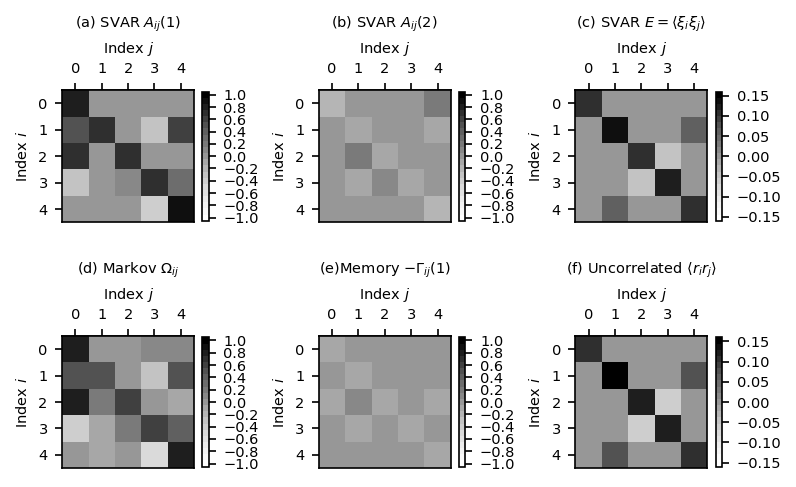

In [13]:
plt.rcParams["font.size"]=7
plt.rcParams["axes.titlesize"]=7

model="model1"
p_svar=2
m_svar=5
coeff_svar = np.loadtxt("./coefficients_"+str(model)+".txt")
B=coeff_svar.reshape(p_svar+1,m_svar,m_svar)
Vinv = np.linalg.inv(np.identity(m_svar)-B[0,:,:])

A1 = np.dot(Vinv,B[1,:,:])
A2 = np.dot(Vinv,B[2,:,:])
Exi = 0.1*np.dot(Vinv,Vinv.T)

# A1 = omega-memoryf[0]
# A2 = -memoryf[1]
# A3 = -memoryf[2]

from matplotlib import colors
cmap = plt.cm.Greys
bounds = np.linspace(-1.05, 1.05, 22)
norm = colors.BoundaryNorm(bounds, cmap.N)

fig=plt.figure(figsize=(5.3,3.5),dpi=150)
ax=fig.add_subplot(231)
quad = ax.pcolormesh(np.arange(m),np.arange(m),A1,
                     cmap=cmap,norm=norm,shading="auto")
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"(a) SVAR $A_{ij}(1)$")
# ax.set_title(r"$A_1[i,j]$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
secax.set_xlim(0-0.5,m-0.5)
secax.set_xticks(np.arange(m_svar))
ax.set_xticks([])
ax.set_ylim(m-0.5,0-0.5)
ax.set_yticks(np.arange(m_svar-1,-1,-1))
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 11),shrink=0.68)
ax.set_aspect("equal")


ax=fig.add_subplot(232)
quad = ax.pcolormesh(np.arange(m),np.arange(m),A2,
                     cmap=cmap,norm=norm,shading="auto")
ax.set_ylim(m-0.5,0-0.5)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"(b) SVAR $A_{ij}(2)$")
# ax.set_title(r"$A_2[i,j]$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
secax.set_xlim(0-0.5,m-0.5)
secax.set_xticks(np.arange(m_svar))
ax.set_xticks([])
ax.set_ylim(m-0.5,0-0.5)
ax.set_yticks(np.arange(m_svar-1,-1,-1))
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 11),shrink=0.68)
ax.set_aspect("equal")


ax=fig.add_subplot(234)
quad = ax.pcolormesh(np.arange(m),np.arange(m),omega-memoryf[0],
                     cmap=cmap,norm=norm,shading="auto")
ax.set_ylim(m-0.5,0-0.5)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"(d) Markov $\Omega_{ij}$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
secax.set_xlim(0-0.5,m-0.5)
secax.set_xticks(np.arange(m_svar))
ax.set_xticks([])
ax.set_ylim(m-0.5,0-0.5)
ax.set_yticks(np.arange(m_svar-1,-1,-1))
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 11),shrink=0.68)
ax.set_aspect("equal")

ax=fig.add_subplot(235)
quad = ax.pcolormesh(np.arange(m),np.arange(m),-memoryf[1],
                     cmap=cmap,norm=norm,shading="auto")
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"(e)Memory $-\Gamma_{ij}(1)$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
secax.set_xlim(0-0.5,m-0.5)
secax.set_xticks(np.arange(m_svar))
ax.set_xticks([])
ax.set_ylim(m-0.5,0-0.5)
ax.set_yticks(np.arange(m_svar-1,-1,-1))
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-1, 1, 11),shrink=0.68)
ax.set_aspect("equal")


bounds = np.linspace(-0.16, 0.16, 22)
norm = colors.BoundaryNorm(bounds, cmap.N)

ax=fig.add_subplot(233)
quad = ax.pcolormesh(np.arange(m),np.arange(m),Exi,
                     cmap=cmap,norm=norm,shading="auto")
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"(c) SVAR $E=\langle \xi_i \xi_j \rangle$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
secax.set_xlim(0-0.5,m-0.5)
secax.set_xticks(np.arange(m_svar))
ax.set_xticks([])
ax.set_ylim(m-0.5,0-0.5)
ax.set_yticks(np.arange(m_svar-1,-1,-1))
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-0.15, 0.15, 7),shrink=0.68)
ax.set_aspect("equal")

ax=fig.add_subplot(236)
quad = ax.pcolormesh(np.arange(m),np.arange(m),rr[0,:,:],
                     cmap=cmap,norm=norm,shading="auto")
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(r"(f) Uncorrelated $\langle r_i r_j \rangle$")
secax = ax.secondary_xaxis('top')
secax.set_xlabel(r'Index $j$')
secax.set_xlim(0-0.5,m-0.5)
secax.set_xticks(np.arange(m_svar))
ax.set_xticks([])
ax.set_ylim(m-0.5,0-0.5)
ax.set_yticks(np.arange(m_svar-1,-1,-1))
ax.set_ylabel(r"Index $i$")
fig.colorbar(quad,ticks=np.linspace(-0.15, 0.15, 7),shrink=0.68)
ax.set_aspect("equal")

fig.tight_layout()
plt.savefig("fig_svar_matrix.pdf")
plt.show()

In [14]:
np.savetxt("./data/A1.txt",A1)
np.savetxt("./data/A2.txt",A2)
np.savetxt("./data/Exi.txt",Exi)
np.savetxt("./data/omega.txt",omega)
np.savetxt("./data/gamma1.txt",memoryf[1,:,:])
np.savetxt("./data/rr0.txt",rr[0,:,:])


In [15]:
im=0
d = y[:,im]
x_hist, bins = np.histogram(d,bins=100)
x_range = (bins[:-1] + bins[1:])/2
bin_width = bins[1]-bins[0]
pdf = x_hist / d.size / bin_width
x_range = (bins[:-1] + bins[1:])/2

im1=0
d1 = y[:,im1]
d1 = d1 - np.average(d1)
ccf = []
for im2 in range(m):
    d2 = y[:,im2]
    d2 = d2 - np.average(d2)
    wccf = np.correlate(d1,d2,mode="full")[len(d1)-1:]
    wccf = wccf / np.sqrt(np.sum(d1*d1)*np.sum(d2*d2))
    ccf.append(wccf)
ccf=np.array(ccf)[:,0:100]
np.savetxt("./data/range_y0_reproduction.txt",x_range)
np.savetxt("./data/pdf_y0_reproduction.txt",pdf)
np.savetxt("./data/ccf_y0_reproduction.txt",ccf)

(100,) (5, 100)


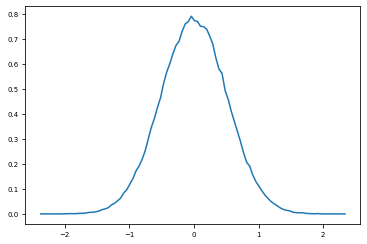

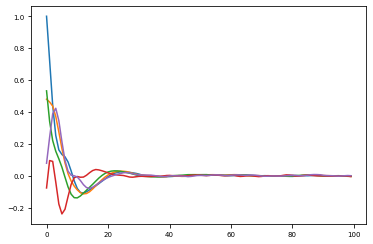

In [16]:
print(pdf.shape,ccf.shape)
plt.plot(x_range,pdf)
plt.show()
plt.plot(ccf.T)
plt.show()